In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torchvision.datasets as vdatasets
import torchvision.transforms as transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import random
import numpy as np
import os
DATA_PATH = os.environ['DATA_PATH']
%matplotlib inline

In [2]:
# Hyper Parameters 
INPUT_SIZE = 784
HIDDEN_SIZE = 256
LATENT_SIZE = 5
EPOCH = 50
BATCH_SIZE = 100
LR = 0.001

In [3]:
# MNIST Dataset (Images and Labels)
train_dataset = vdatasets.MNIST(root=DATA_PATH+'MNIST/', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)

# Dataset Loader (Input Pipline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True)

In [16]:
class VAE(nn.Module):
    def __init__(self,input_size=784,hidden_size=256,z_size=5):
        super(VAE,self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, z_size*2))
        
        self.decoder = nn.Sequential(
            nn.Linear(z_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, input_size),
            nn.Sigmoid())
        
    def reparameterize(self, mu, log_var):
        """z = mu + e*sigma"""
        eps = Variable(torch.randn(mu.size()))
        z = mu + eps * torch.exp(log_var/2)  
        return z
                     
    def forward(self, x):
        h = self.encoder(x)
        mu, log_var = torch.chunk(h, 2, dim=1)  # mean and log variance.
        z = self.reparameterize(mu, log_var)
        out = self.decoder(z)
        return out, mu, log_var
    
    def sample(self, z):
        return self.decoder(z)

In [17]:
def kl_divergence(mu,log_var):
    """0.5 * sum(mu^2 + sigma^2 - log(sigma^2) - 1)"""
    return torch.sum(0.5 * (mu**2 + torch.exp(log_var) - log_var -1))

In [22]:
model = VAE()
optimizer = optim.Adam(model.parameters(), lr=LR)

In [23]:
model.train()
for epoch in range(EPOCH):
    for i, (inputs, _) in enumerate(train_loader):
        inputs = Variable(inputs.view(-1, 28*28))
        
        # Forward + Backward + Optimize
        optimizer.zero_grad()
        recon, mu, log_var = model(inputs)
        loss = F.binary_cross_entropy(recon, inputs,size_average=False) + kl_divergence(mu,log_var)
        loss.backward()
        optimizer.step()
        
        if (i+1) % 300 == 0:
            print ('Epoch: [%d/%d], Step: [%d/%d], Loss: %.4f' 
                   % (epoch+1, EPOCH, i+1, len(train_dataset)//BATCH_SIZE, loss.data[0]))
            
# 생성 이미지 샘플 저장
normal = Variable(torch.randn(50,LATENT_SIZE)) # p(z)
sampled_image = model.sample(normal)
sampled_image = sampled_image.view(50,1,28,28)
save_image(sampled_image.data, './images/vae_gen_images.png')

Epoch: [1/50], Step: [300/600], Loss: 14534.5625
Epoch: [1/50], Step: [600/600], Loss: 14141.9502
Epoch: [2/50], Step: [300/600], Loss: 14035.9502
Epoch: [2/50], Step: [600/600], Loss: 14169.2617
Epoch: [3/50], Step: [300/600], Loss: 12949.2588
Epoch: [3/50], Step: [600/600], Loss: 13195.1641
Epoch: [4/50], Step: [300/600], Loss: 12888.3311
Epoch: [4/50], Step: [600/600], Loss: 12215.9219
Epoch: [5/50], Step: [300/600], Loss: 13456.4326
Epoch: [5/50], Step: [600/600], Loss: 12825.9834
Epoch: [6/50], Step: [300/600], Loss: 12109.8223
Epoch: [6/50], Step: [600/600], Loss: 12859.3330
Epoch: [7/50], Step: [300/600], Loss: 12437.1621
Epoch: [7/50], Step: [600/600], Loss: 13290.8232
Epoch: [8/50], Step: [300/600], Loss: 11767.6982
Epoch: [8/50], Step: [600/600], Loss: 12842.3340
Epoch: [9/50], Step: [300/600], Loss: 13385.4141
Epoch: [9/50], Step: [600/600], Loss: 13035.7988
Epoch: [10/50], Step: [300/600], Loss: 12365.8164
Epoch: [10/50], Step: [600/600], Loss: 12731.2178
Epoch: [11/50], St

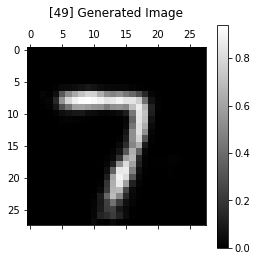

In [24]:
z = Variable(torch.randn(1,5)) #  z ~ p(z)
image = model.sample(z)

plt.matshow(np.reshape(image.data.numpy(), (28, 28)), cmap=plt.get_cmap('gray'))
plt.title("[" + str(epoch) + "] Generated Image\n")
plt.colorbar()
plt.show()
